[#air-polution-sensor](https://github.com/Johansmm/air-polution-sensor)

 # Analyse spatio-temporelle de signaux pour détecter la dérive de capteurs mesurant la qualité de l'air
 
 Project summary (coming soon) ...

## **Introduction**

In [1]:
# Libraries
# Basis libraries 
import sys, getpass, os, copy
import numpy as np
import scipy.signal
from matplotlib import rc
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import scipy.signal
import ipywidgets

# Library for boxplots
# font = {'family':'sans-serif','sans-serif':['Helvetica'], 'size':18}
# rc('font', **font)
# rc('text', usetex=True)

In [2]:
# Colab access
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

# If you work-directory don't match, please add the new path to pwd_list
cwd_list = ["/content/gdrive/My Drive/S5 Project: Air polution/air-polution-sensor/",
            "/content/gdrive/My Drive/Colab Notebooks/ProyectS5/air-polution-sensor/",
            "/content/drive/MyDrive/IMT Atlantique/Project_S5_Air/",
            os.path.join(os.getcwd(),"air-polution-sensor")]


for cwd in cwd_list:
    if os.path.isdir(cwd):
        %cd "$cwd"
        break
if os.path.split(os.getcwd())[-1] != "air-polution-sensor":
    print("[WARNING]: Incorrect working directory. Please add the fix-directory to the pwd_list.")
else: 
    print("[INFO]: Work directory: " + os.getcwd())

[INFO]: Work directory: /mnt/d/Nextcloud/2nd semestre/air-polution-sensor


## **Download repository**
First, we will download the repository that contains the project [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git). This process is optional, being necessary to activate the flag `download_repo` and enter the `user`, `email` and `password` of the repository (since the repository is initially private). Additionally you can enable the `download_db` option to download the database.

In [3]:
if not os.path.isdir("./data/origin_data"):
    if not os.path.isdir("./data"): os.mkdir("./data")
    if not os.path.isdir("./data/origin_data"): os.mkdir("./data/origin_data")
    !wget --output-document="./data/data.zip" "https://www.dropbox.com/sh/w1704rg9fd9z4pq/AABG3YCUMHTwbFhf3pKgti-Qa/PuneData_UseThis/August2019?dl=0&subfolder_nav_tracking=1"
    !unzip "./data/data.zip" -d "./data/origin_data"

if not os.path.isfile("./data/super_df.csv"):
    !unrar x "./data/super_df.rar" "./data/"

clear_output(wait = True)
print("[INFO]: Data downloaded successfully!")

[INFO]: Data downloaded successfully!


In [4]:
# Specefic libraries
%load_ext autoreload
%autoreload 2
!pip install -r requirements.txt
from libraries.global_functions import *
from libraries.animation_utils import *

# Random seed
np.random.seed(0)
clear_output(wait = True)
print("[INFO]: Successfully loaded libraries!")

[INFO]: Successfully loaded libraries!


In [5]:
if IN_COLAB:
    !sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
    clear_output(wait = True)
else:
    print("[INFO]: If you have problems, remember execute the following code:\n>> sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config")

[INFO]: If you have problems, remember execute the following code:
>> sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config


## **Examples of library uses**

In order to explain some function of `global_functions` library, let's start with three particulars examples:
1. Replication of results to verify library functionality
2. Simple example with signal traveling through the network.
3. Drift example.

### **Function performance**

In this section we will verify the functionality of the library with the estimation of some results of the `Vertex-Frequency Analysis on Graphs` article (Shuman D. 2013). Specifically, we will focus the analysis to "replicate" the results of figures 14 and 15 of this article.

**Note:** It is clarified that the exact results cannot be obtained, because the exact information of the network configuration is not available.

Let's start with the definition of the network and the signal at each node.

In [13]:
# Constants
SPACE_GRAPH_ORDER = 64

# Graph definition
groups = np.array([0]*(SPACE_GRAPH_ORDER//2) + [1]*(SPACE_GRAPH_ORDER - SPACE_GRAPH_ORDER//2))
graph = create_stochastic_graph(SPACE_GRAPH_ORDER, k = 2, z = groups, p=[0.25, 0.25], q = 0.01)

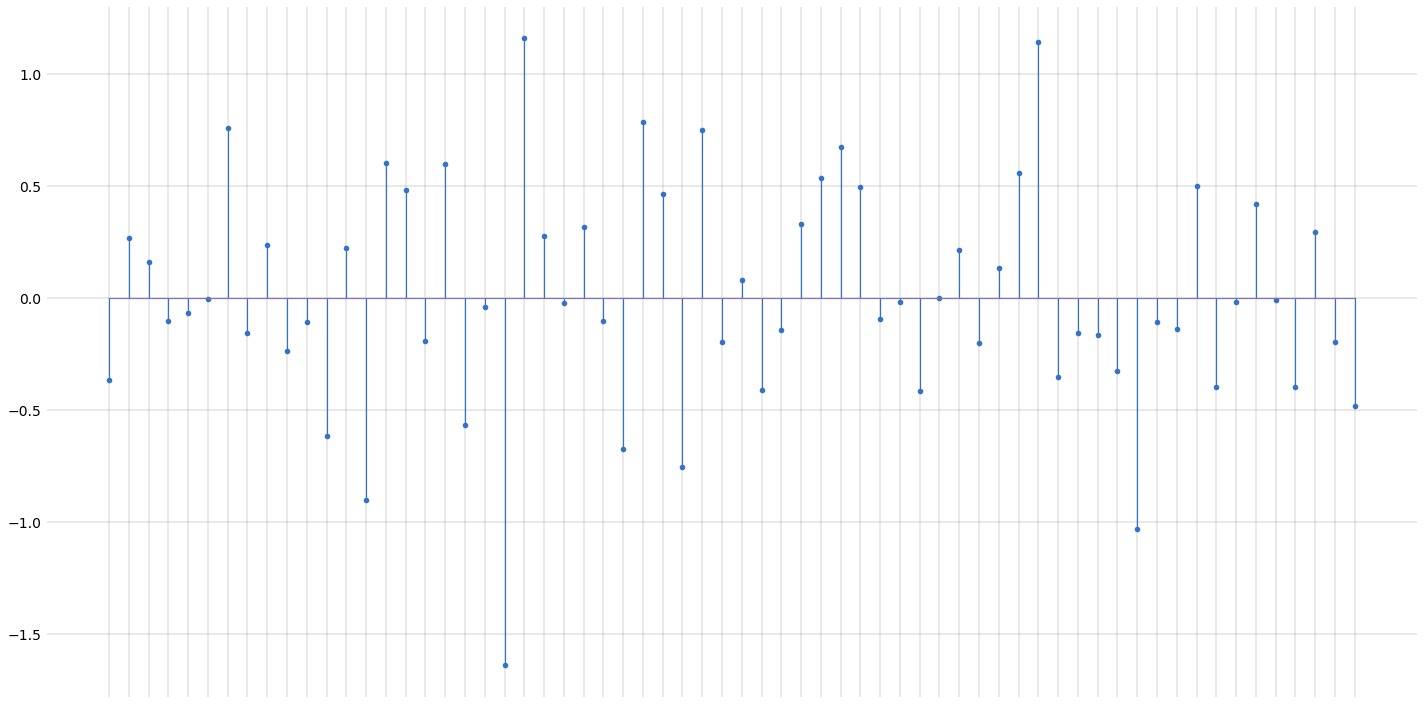

In [14]:
# Signal definition
sig_vert = np.concatenate((graph.U[:32,15]/np.max(np.abs(graph.U[:32,15])), graph.U[32:,8]/np.max(np.abs(graph.U[32:,8]))))
sig_vert += np.concatenate((graph.U[:32,34]/np.max(np.abs(graph.U[:32,34])), graph.U[32:,55]/np.max(np.abs(graph.U[32:,55]))))
# sig_vert /= numpy.linalg.norm(sig_vert)
plot_stem(sig_vert)

The result of graphing the different eigenvectors on the architecture would be:

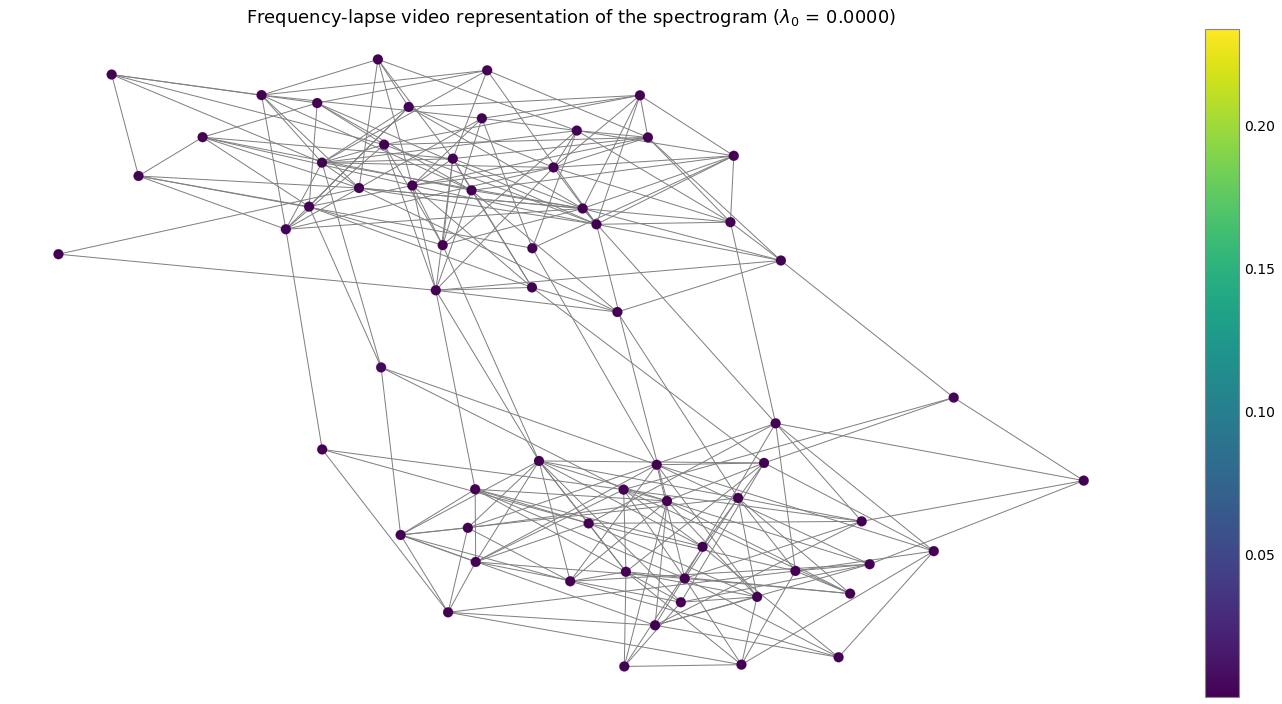

<function libraries.animation_utils.eigenvec_anima.<locals>.update(instant, animation=False)>

In [15]:
SPACE_KERNEL_SCALE = 10
eigenvec_anima(graph, sig_vert, SPACE_KERNEL_SCALE)

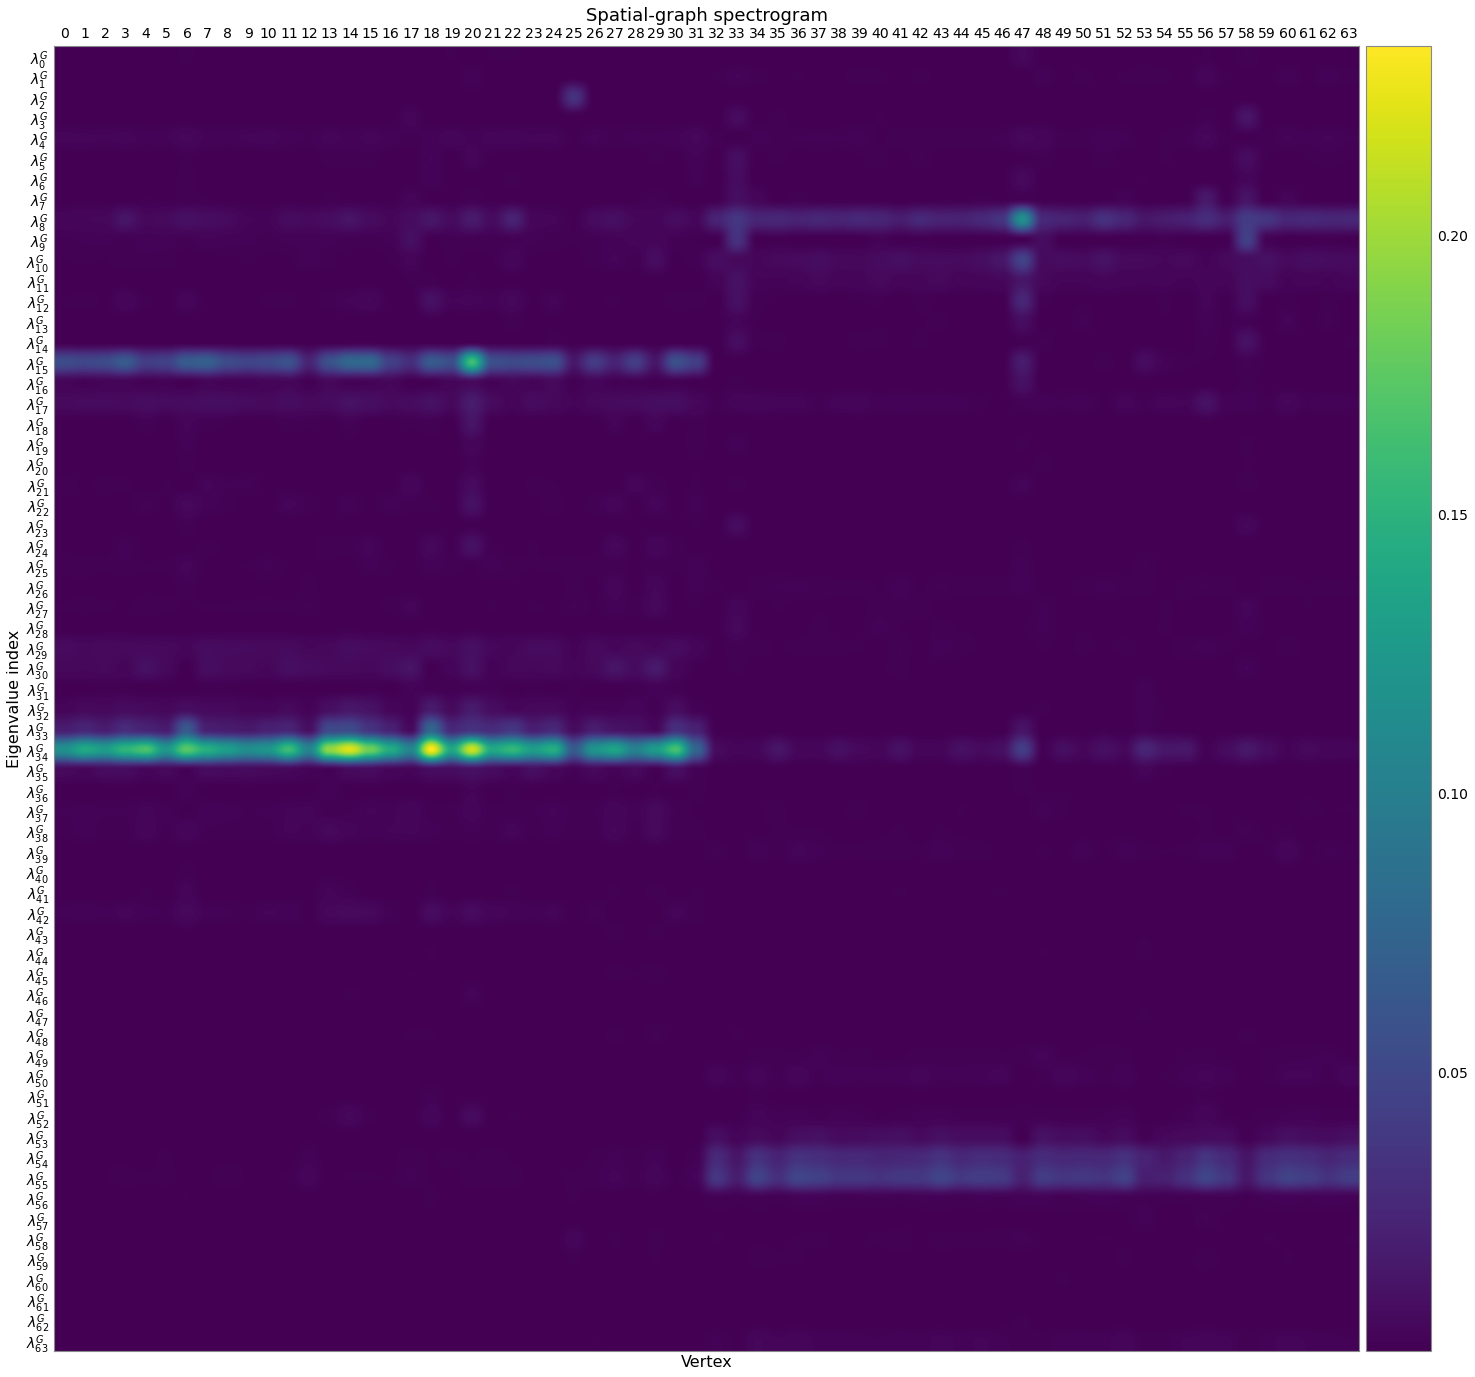

In [16]:
window_kernel = create_heat_kernel (graph, SPACE_KERNEL_SCALE)
spectrogram = compute_graph_spectrogram (graph, sig_vert, window_kernel)
plot_matrix(spectrogram, cols_title = "Vertex", cols_labels=range(graph.N), rows_title="Eigenvalue index", 
            colorbar=True, rows_labels=["$\lambda^G_{" + str(x) + "}$" for x in range(graph.N)], title="Spatial-graph spectrogram")

### **Signal traveling in the network**

Let's create two graphs that will represent the spatial and temporal dimension, respectively. The spatial network will be represented by a stochastic network (`create_stochastic_graph`), while the temporal notion will be provided by a path network (`create_path_graph`).

In [17]:
# Constants
SPACE_GRAPH_ORDER, SPACE_KERNEL_SCALE = 40, 20
TIME_GRAPH_ORDER, TIME_KERNEL_SCALE = 50, 20
dT = 10.0/TIME_GRAPH_ORDER # Time sample
LEVEL_NOISE = 0.1

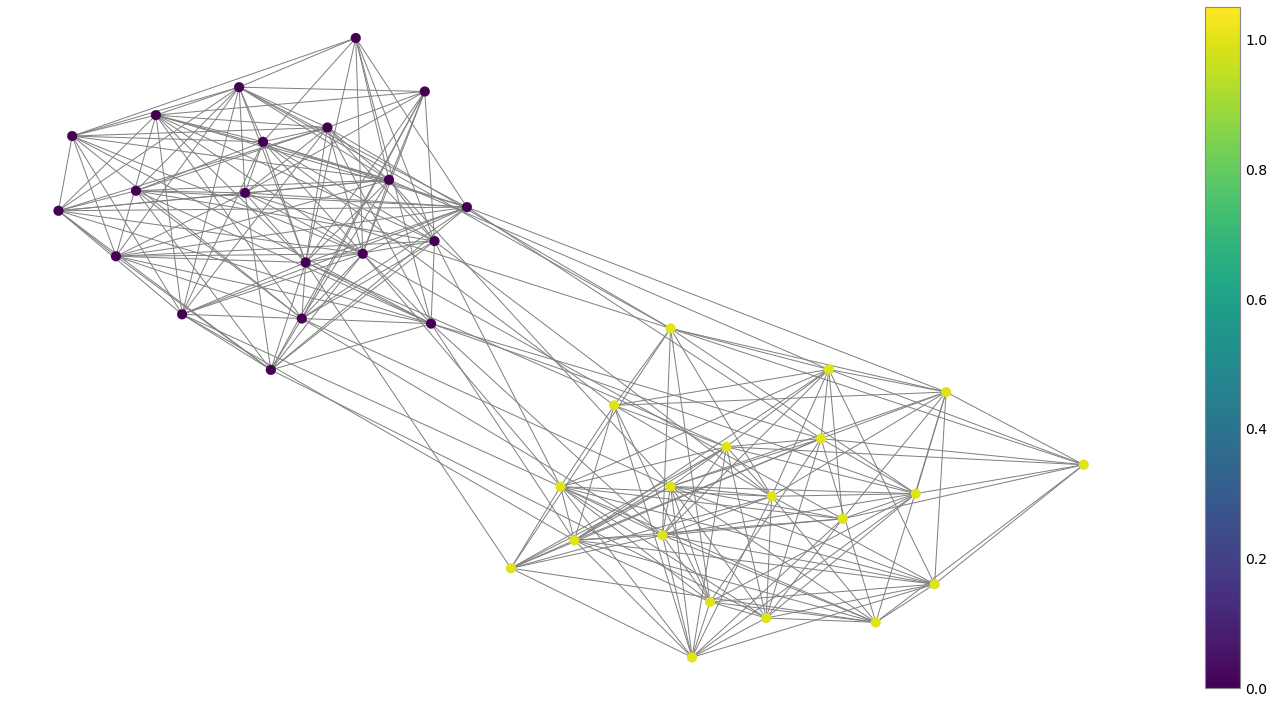

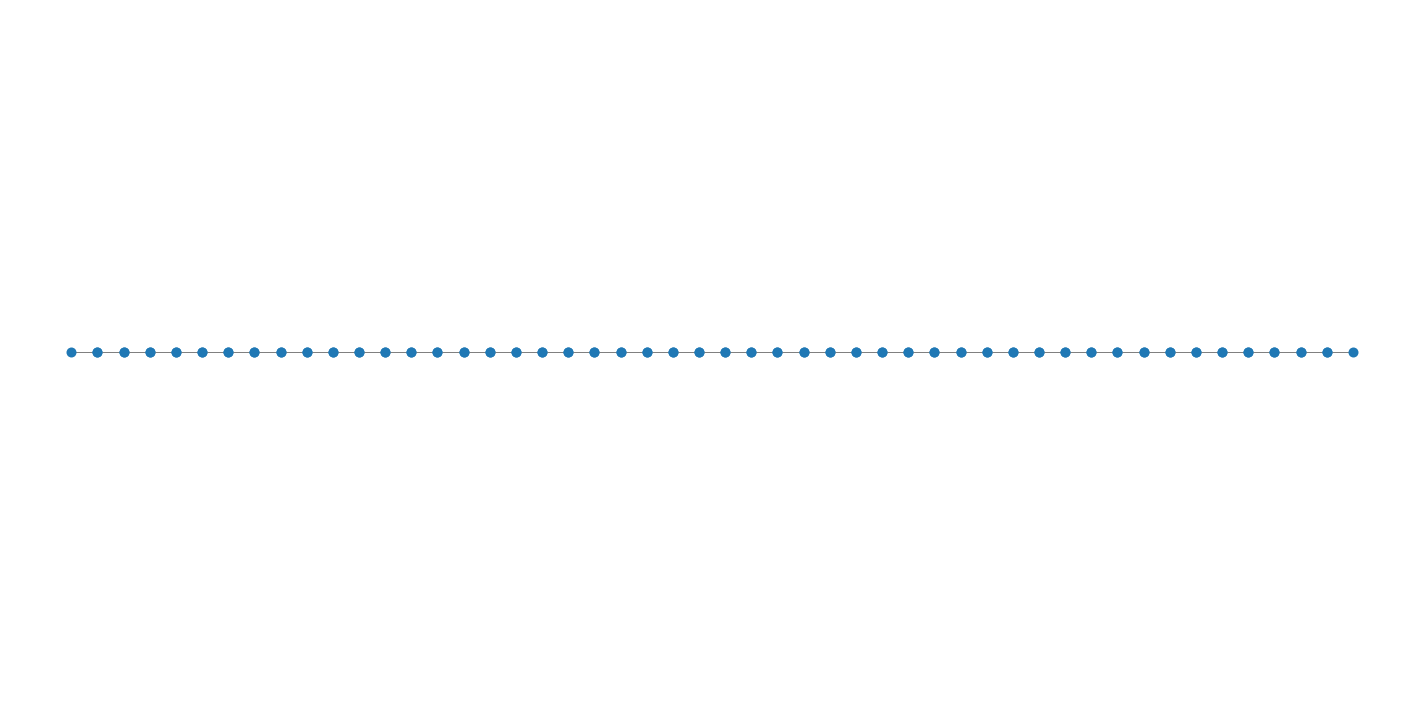

In [18]:
# Space-time graph definition
groups = np.array([0]*(SPACE_GRAPH_ORDER//2) + [1] * (SPACE_GRAPH_ORDER - SPACE_GRAPH_ORDER//2))
space_time_graph = [create_stochastic_graph(SPACE_GRAPH_ORDER, k = 2, z = groups, p=[0.6, 0.6], q = 0.05), 
         create_path_graph(TIME_GRAPH_ORDER)]

plot_graph(space_time_graph[0], groups)
plot_graph(space_time_graph[1])

#### **Time variance function**

In this section is shown a function capable of showing the variation of the network in time

Now, we will define a time series for each group of nodes present in the space network. We will then take an increasing signal for the group of nodes labeled '0', and a decreasing signal for the remaining nodes, giving us the notion that the signal "is traveling" from group 1 to group 0. We will add some white noise for general purposes.

In order to visualize and understand how the signal "travels" through the network, a time-dependent simulation was fabricated.

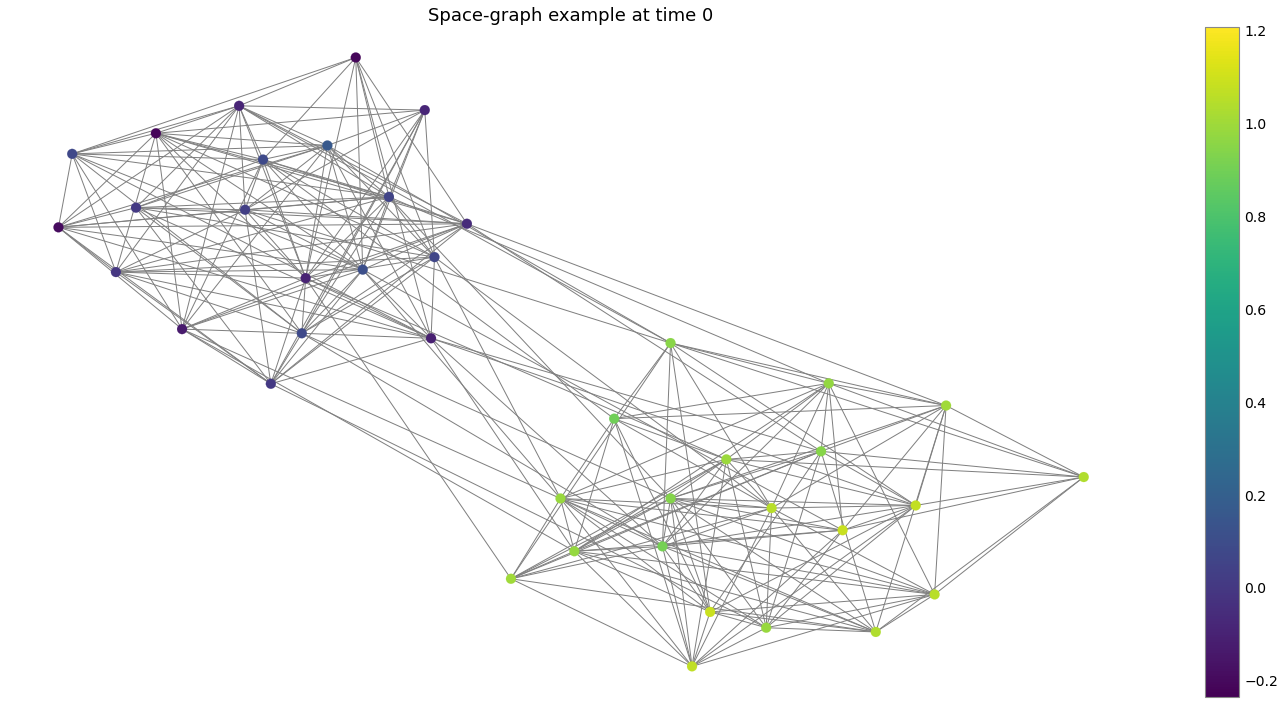

<function libraries.animation_utils.signal_graph_anima.<locals>.update(instant, animation=False)>

In [19]:
# Create a simple graph signal (sigmoid for group0 and inverse sigmoid for group1)
def signal_def(SGO = SPACE_GRAPH_ORDER, TGO = TIME_GRAPH_ORDER, dT = dT, plot_fun = False, nl = 0.01): 
    t = np.linspace(0, TIME_GRAPH_ORDER*dT, TIME_GRAPH_ORDER)
    sig = 1/(1 + np.exp(-t + 0.5*TIME_GRAPH_ORDER*dT)) # Sigmoid fun
    sig_inv = 1/(1 + np.exp(t - 0.5*TIME_GRAPH_ORDER*dT)) # Sigmoid inverse fun
    time_series = np.zeros((SGO,TGO))
    time_series[:SGO//2, :], time_series[SGO//2:, :] = sig, sig_inv
    time_series += nl*np.random.randn(*time_series.shape)
    
    if plot_fun: # If we want, we can show the both function in a new plot
        fig, ax = plt.subplots(ncols = 2, figsize=(12,6))
        t_mid = str(round(0.5*TIME_GRAPH_ORDER*dT,2))
        ax[0].plot(t, time_series[SGO//2 - 10, :]); ax[1].plot(t, time_series[SGO//2 + 10, :])
        ax[0].set_ylabel("$\\frac{1}{1+\exp(-x + " + t_mid + ")}$"); ax[0].set_xlabel("$x$")
        ax[1].set_ylabel("$\\frac{1}{1+\exp(x - " + t_mid + ")}$"); ax[1].set_xlabel("$x$")
        ax[0].grid("minor"); ax[1].grid("minor"); plt.show()
    return time_series

time_series = signal_def(space_time_graph[0].N, space_time_graph[1].N, dT, nl = LEVEL_NOISE, plot_fun = False)
signal_graph_anima(space_time_graph, time_series)

#### **GFT in time and space**

In this section we present functions to calculate the graph fourier transform in time and space

To check that the desired signal was processed correctly, the signal on a particular node and its Graph Fourier Transform (GFT) can be displayed with the following code section. Remember that the signal for the same group of nodes is the same. This can be seen again in the next cell, where the same procedure is presented for the temporary graph.

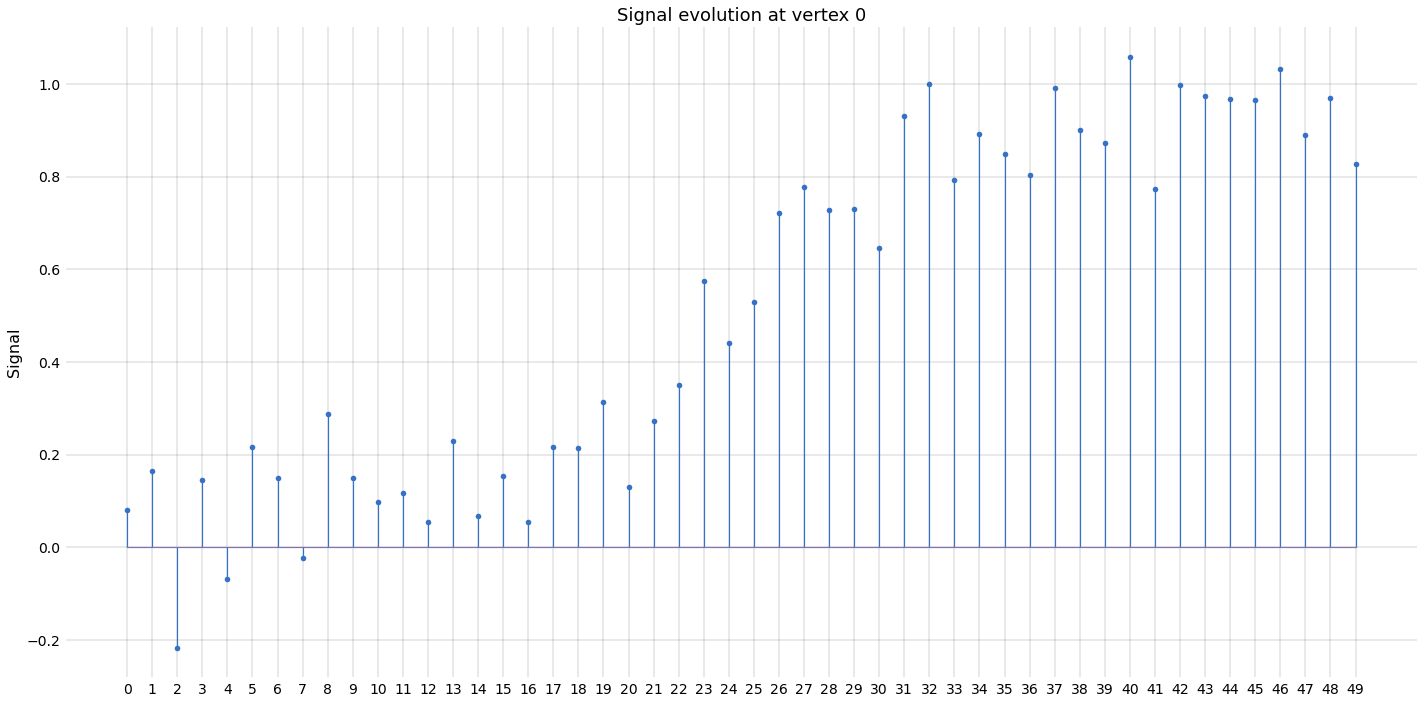

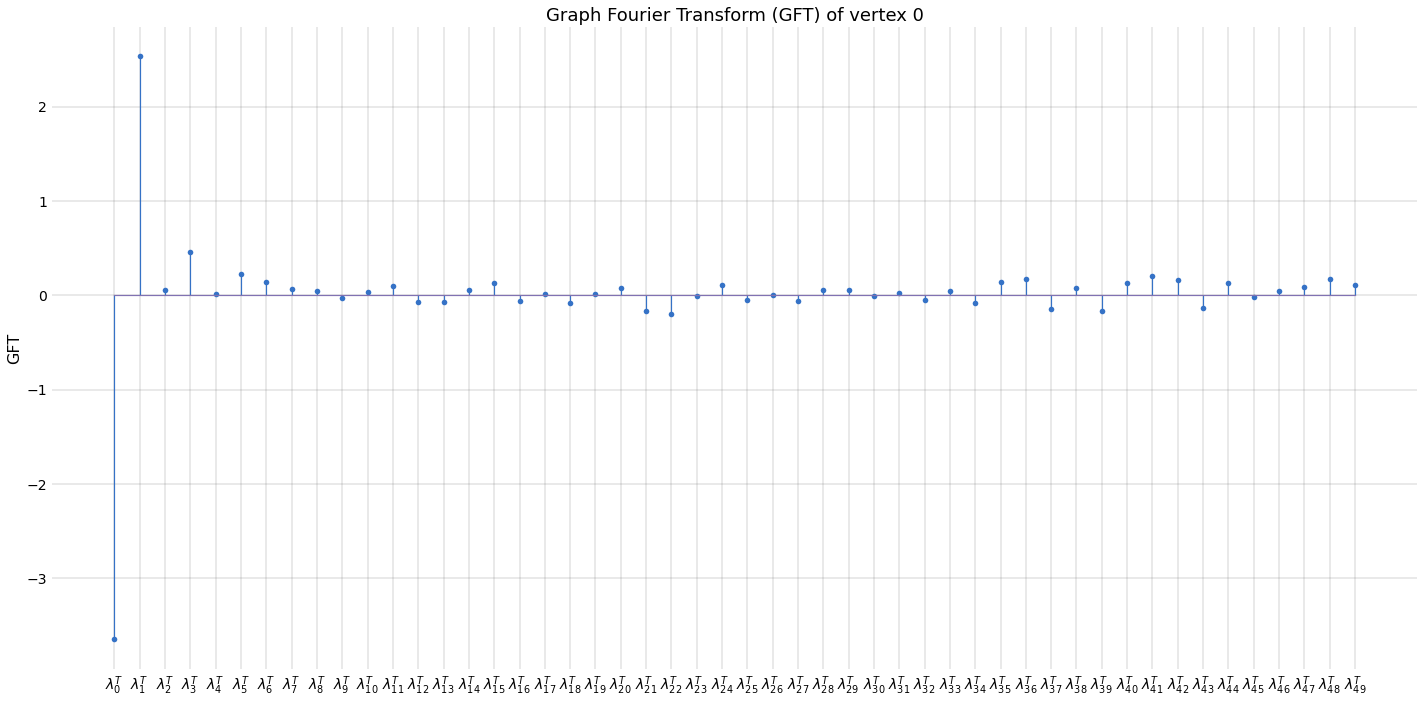

<function libraries.animation_utils.gft_signal_anima.<locals>.update(value)>

In [20]:
gft_signal_anima(space_time_graph[1], time_series, is_graph_space = True)

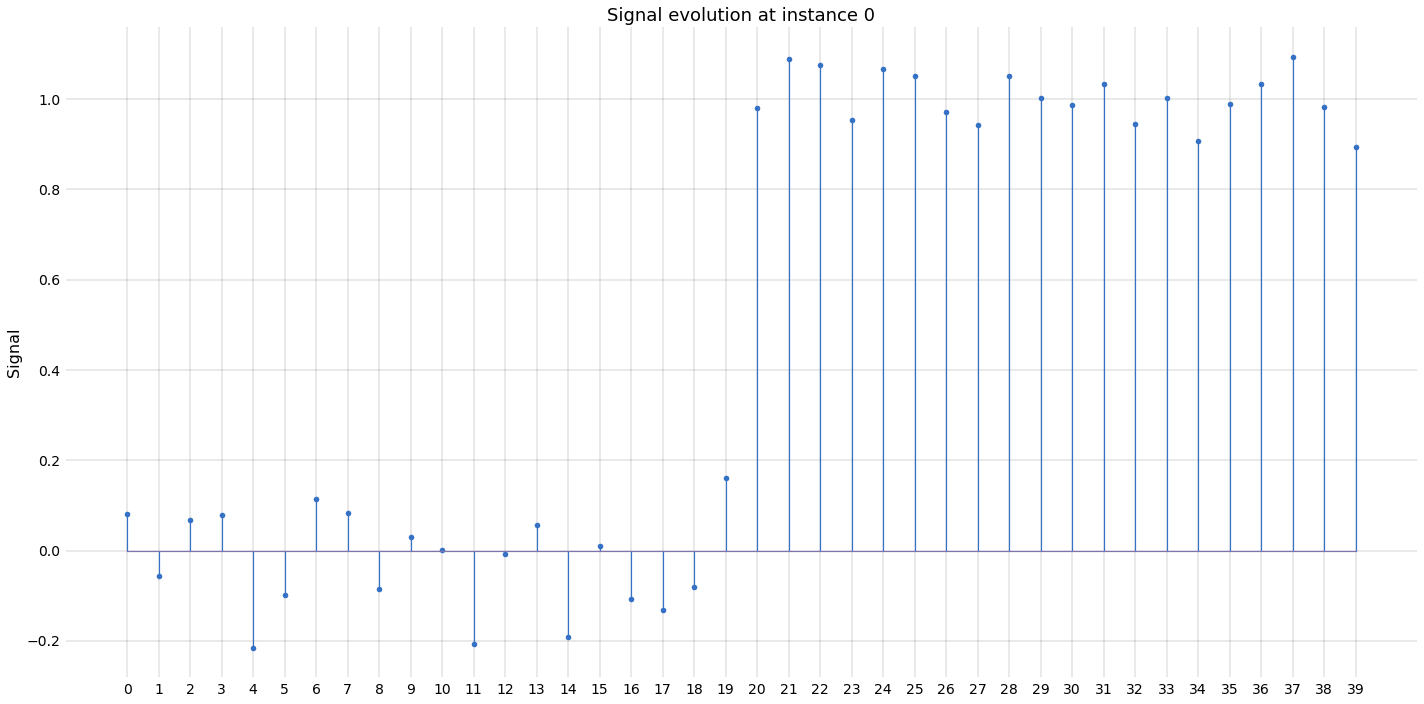

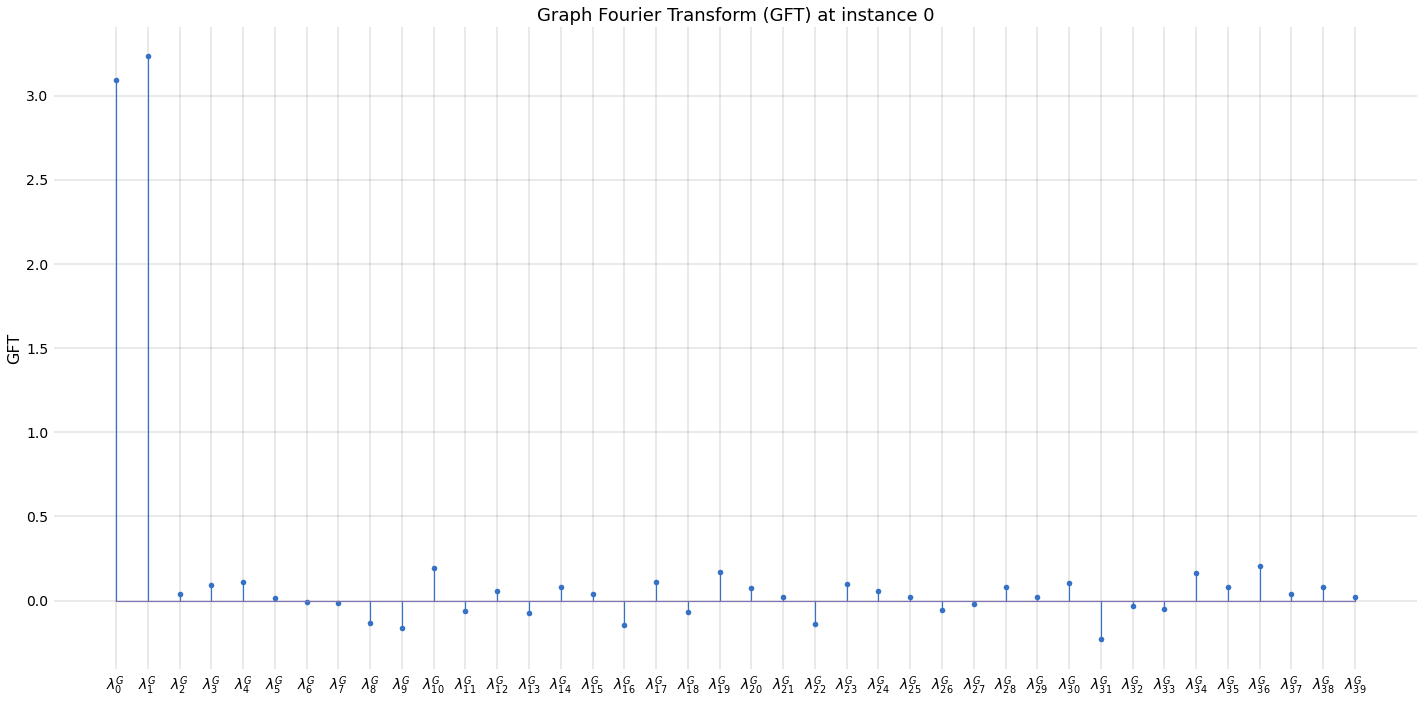

<function libraries.animation_utils.gft_signal_anima.<locals>.update(value)>

In [21]:
gft_signal_anima(space_time_graph[0], time_series, is_graph_space = False)

Having correctly defined the signal to use, let's make a joint analysis of the space-time graph. 

#### **Spectrogram for disjoint GFT**

To have a more detailed understanding, we will first analyze the graphs separately. The following function allows to display the spectrogram of each network by selecting a specific time (for the spatial graph) or a specific vertex (for the temporal graph), depending on the case.

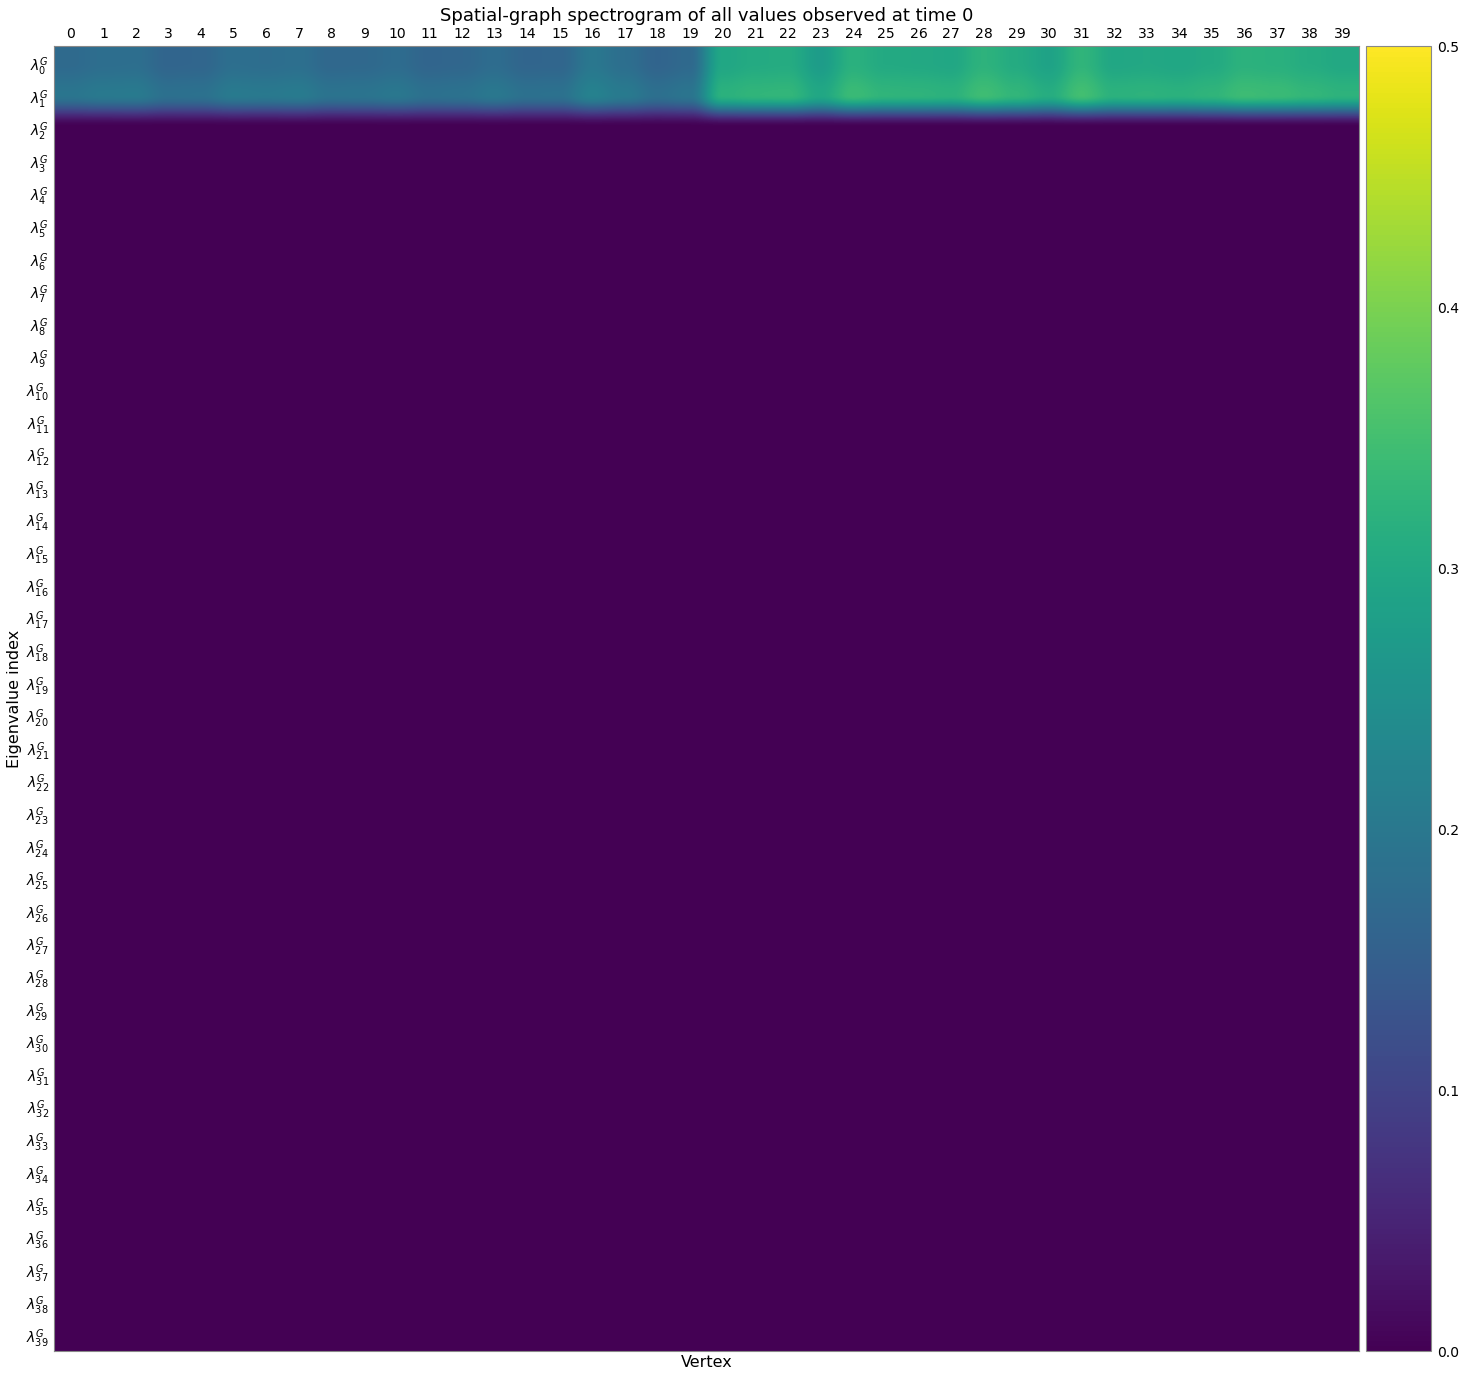

<function libraries.animation_utils.spectogram_anima.<locals>.update(value, autoadj=False, interpolate=True)>

In [22]:
spectogram_anima(space_time_graph[0], time_series, SKS = SPACE_KERNEL_SCALE, is_graph_space = True, limits = [0.0, 0.5])

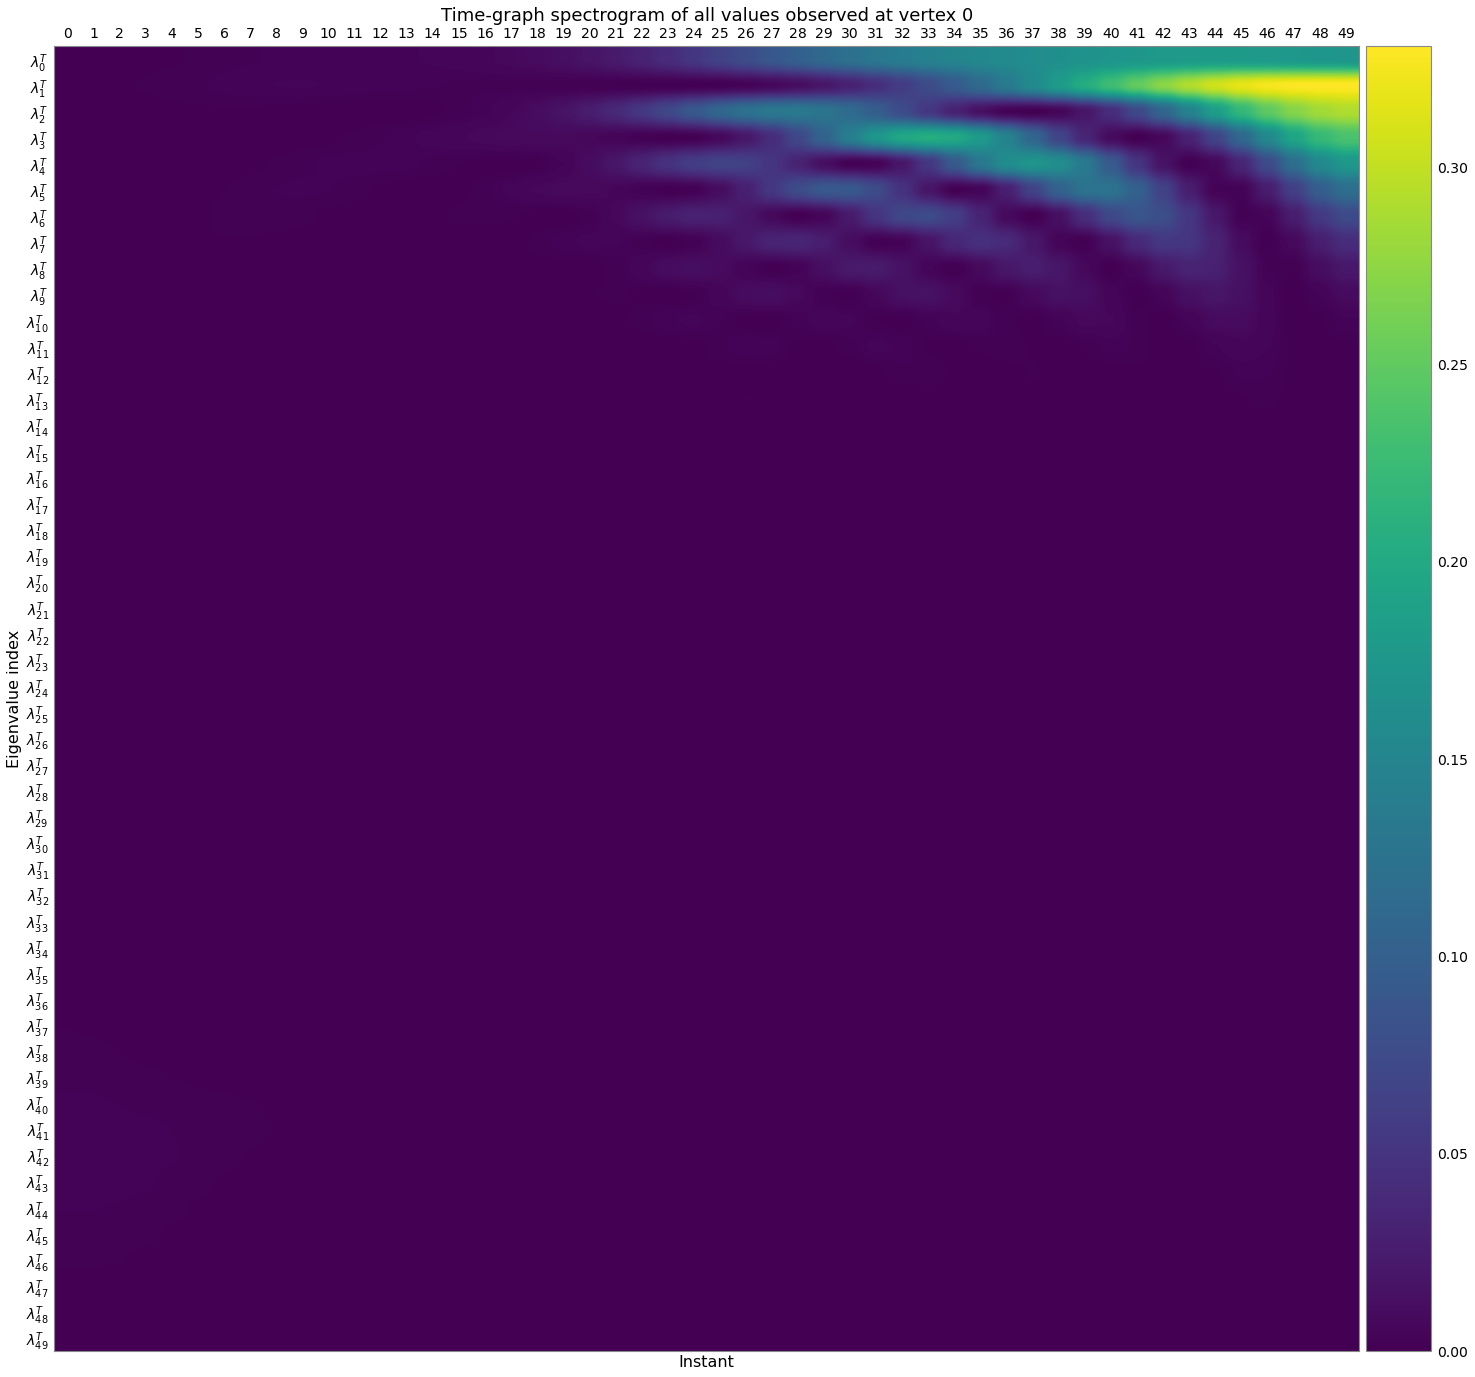

<function libraries.animation_utils.spectogram_anima.<locals>.update(value, autoadj=False, interpolate=True)>

In [23]:
spectogram_anima(space_time_graph[1], time_series, SKS = TIME_KERNEL_SCALE, is_graph_space = False, limits = None)

* **Spatial-graph:** Let's remember that all the vertices in a group have the same signal, so, in a specific instant of time, the signal of each node is "constant". This is represented in the graphical-spatial spectrogram, where the only eigenvalues with considerable magnitudes are those of low order, which represent the low frequencies. As time passes, we see how the magnitudes of the nodes in group 0 begin to decrease, while those in group 1 begin to increase. However, this only happens at low frequencies.

* **Time-graph:** Focusing on the signal from only one particular node, we know that changes in sigmoidal and inverse sigmoidal signals are smooth, so your spectrogram will have non-null values in low order eigenvalues. Unlike the spatial spectogram, the presence of eigenvalues with magnitudes different from zero is evident, since the signal $s(v_i, t)$ for the vertex $v_i$ changes with time, unlike its counterpart, whose signal $s(v, t_j)$ is "constant" (without considering the introduced noise) at time $t_j$ for a group of vertices.  Finally, it is appreciated that, for the nodes of group0, the magnitudes of the spectogram increase through time, unlike the nodes of group0, whose behavior is inverse. 

#### **Spectrogram for joint GFT**

Now we will enter to observe the properties of the space-time joint spectrogram. This is possible thanks to the following function. Since the joint spectrogram is in principle a two-dimensional array for each possible combination in space and time, we have as a result an array in $\mathbb{R}^4$, being useful to indicate a specific vertex and instant, looking for interpretability.

In [44]:
kernel_anima(space_time_graph, (15,10), windows_kernels = [1, 15])

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.kernel_anima.<locals>.update(instant, autoadj=False, animaton=False)>

In [45]:
kernels, joint_spectogram = JFT_anima(space_time_graph, time_series, [3, 8])

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

Taking into account that the joint spectrogram estimates different spectrograms, each of them centered on the combination ($v_i$, $t_j$), the analysis of the results should be done for each possible combination, arriving at the following statements:

1.  As explained above, the process occurs at "low frequencies" for any possible event, both in space and time, which directly affects the joint spectrogram, being only possible to see non-zero magnitudes in the upper left region (low orders of eigenvalues of space and time).
2.  The signal $s(v_i,t)$ has more frequency components compared to the signal $s(v,t_i)$, being possible to observe in the spectrogram for any combination. The reason is explained above.
3.  The magnitudes of the spectrogram for the combinations in the first instants of time and $v_i \in$ group0 or final instants of time and $v_i \in$ group1 are of low value in comparison to their counterpart, respectively. This is consistent with the shape of the signal at each vertex and for each instant of time.

### **Drift example**

#### Graph-signal definition

In [46]:
# Constants
SPACE_GRAPH_ORDER_D, SPACE_KERNEL_SCALE_D = 64, 4#3
TIME_GRAPH_ORDER_D, TIME_KERNEL_SCALE_D = 100, 1000#20
ddT = 10.0/TIME_GRAPH_ORDER_D # Time sample
LEVEL_NOISE_D, BREAK_TIME_D, STD_D = 0.2, 20, 0.3 # LN, brownian Motion (BM) start-point and SD in BM

In [47]:
# Functions to signal definition
def brownian(x0, n, dt, delta, out = None):
    # https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html
    x0 = np.asarray(x0)
    
    # For each element of x0, generate a sample of n numbers from a normal distribution.
    r = np.random.normal(0.0, delta, x0.shape + (n,))*np.sqrt(dt)
    
    # If `out` was not given, create an output array.
    if out is None: out = np.empty(r.shape)
        
    # This computes the Brownian motion by forming the cumulative sum of the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    return out
    
def drift_signal(SGO = SPACE_GRAPH_ORDER_D, TGO = TIME_GRAPH_ORDER_D, BT = BREAK_TIME_D, 
                 dT = 1.0, nl = 0.01, delta = 2.0, groups = None):
    if groups is None:
        signal = np.sin(np.linspace(0, (TGO//BT)*4*np.pi, TGO)) # Signal base (until BREAK_TIME)
        time_series = np.ones((SGO,1))*signal[None] # Same signal for all nodes
    else:
        time_series = []
        for i in groups:
            t0 = 2*np.pi*i/len(np.unique(groups))
            time_series += [np.sin(np.linspace(0,(TGO//BT)*4*np.pi, TGO) + t0)]
        time_series = np.stack(time_series, axis = 0)
            
    time_series += nl * np.random.randn(*time_series.shape) # Add noise
    
    # Add Brownian Motion with t = BT start point
    brownian(time_series[0,BT - 1], TGO - BT, dT, delta, out = time_series[0,BT:])
    return time_series

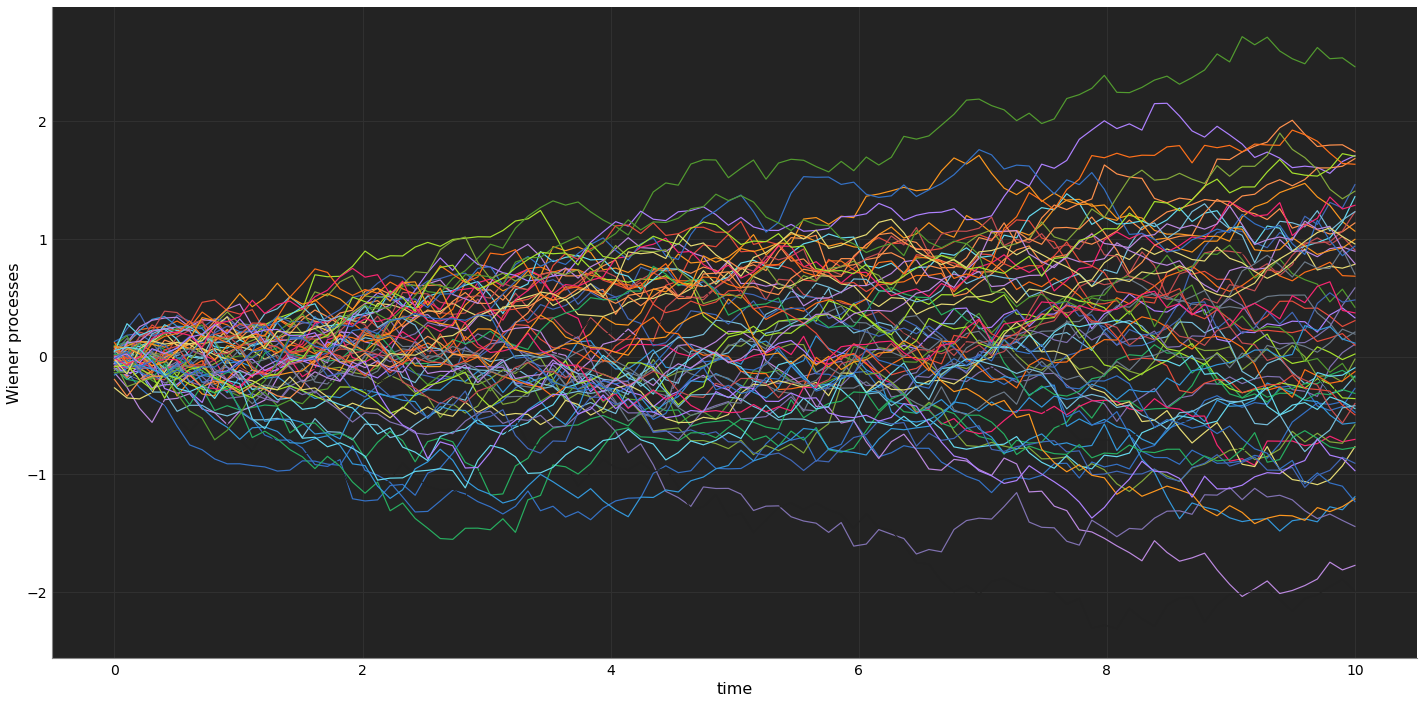

In [48]:
# Example
t = np.linspace(0, TIME_GRAPH_ORDER_D*ddT, TIME_GRAPH_ORDER_D)
t = np.ones((SPACE_GRAPH_ORDER_D,1))*t[None]
y = np.zeros((SPACE_GRAPH_ORDER_D,TIME_GRAPH_ORDER_D))
y = brownian(y[:,0], TIME_GRAPH_ORDER_D, ddT, STD_D)
plot_curves(t, y, xlabel = "time", ylabel = "Wiener processes")#, file_name = "./wiener_process.png")

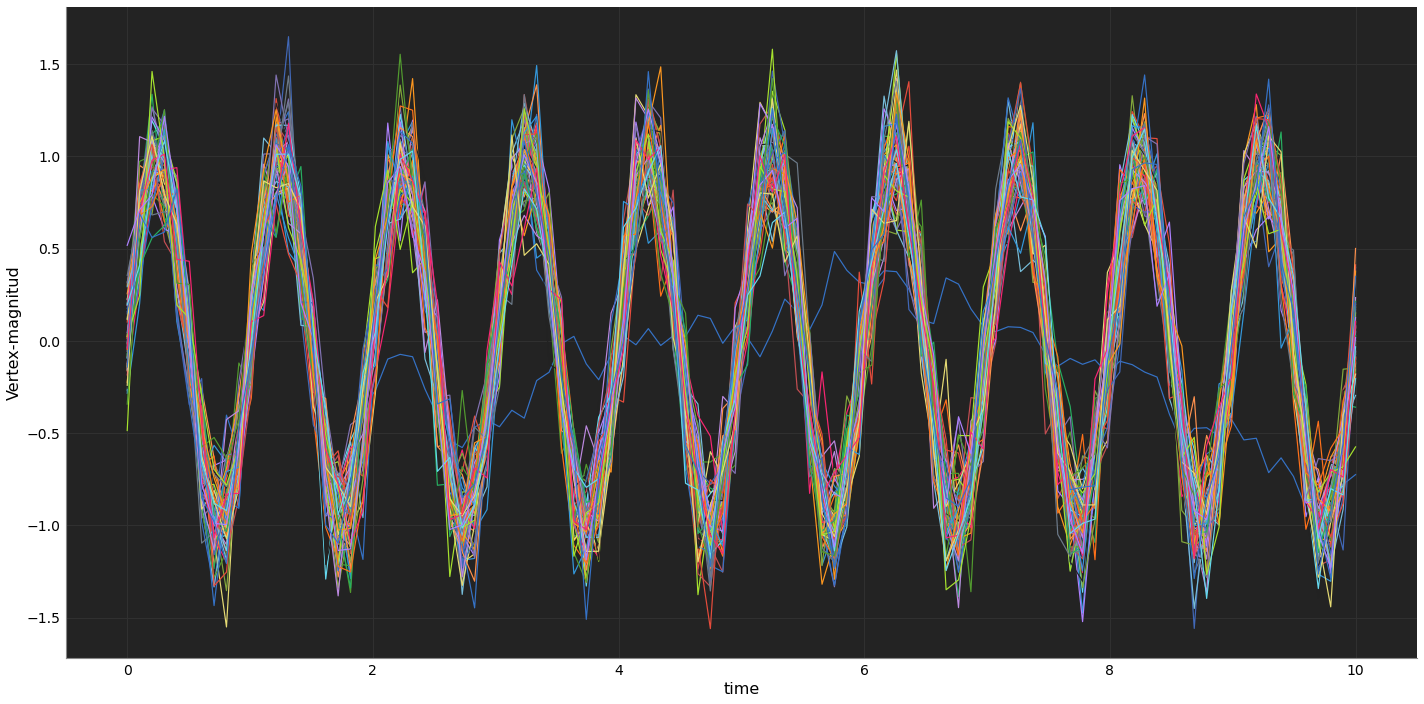

In [49]:
# Space-time graph definition
groups = np.array([0]*32 + [1]*24 + [2]*8)
space_time_drift_graph = [create_stochastic_graph(SPACE_GRAPH_ORDER_D, k = 3, z = groups, p=[0.3, 0.4, 0.8], q = 0.01), 
         create_path_graph(TIME_GRAPH_ORDER_D)]

# Signal definition
#time_drift_series = drift_signal(dT = ddT, nl = LEVEL_NOISE_D, BT = BREAK_TIME_D, delta = STD_D, groups = groups)
time_drift_series = drift_signal(dT = ddT, nl = LEVEL_NOISE_D, BT = BREAK_TIME_D, delta = STD_D)

t = np.linspace(0, TIME_GRAPH_ORDER_D*ddT, TIME_GRAPH_ORDER_D)
t = np.ones((SPACE_GRAPH_ORDER_D,1))*t[None]
plot_curves(t, time_drift_series, xlabel = "time", ylabel = "Vertex-magnitud")
#plot_curves(t[:], time_drift_series, xlabel = "time", ylabel = "Vertex-magnitud")

In [50]:
signal_graph_anima(space_time_drift_graph, time_drift_series)

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.signal_graph_anima.<locals>.update(instant, animation=False)>

#### Spectrum analysis

In [59]:
kernel_anima(space_time_drift_graph, (15,10), windows_kernels = [1, 400])

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.kernel_anima.<locals>.update(instant, autoadj=False, animaton=False)>

In [53]:
spectogram_anima(space_time_drift_graph[0], time_drift_series, SKS = 2, is_graph_space = True)#, limits = [0.0, 0.5])

interactive(children=(Dropdown(description='Instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function libraries.animation_utils.spectogram_anima.<locals>.update(value, autoadj=False, interpolate=True)>

In [54]:
spectogram_anima(space_time_drift_graph[1], time_drift_series, SKS = 8, is_graph_space = False)#, limits = [0.0, 0.5])

interactive(children=(Dropdown(description='Vertex', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function libraries.animation_utils.spectogram_anima.<locals>.update(value, autoadj=False, interpolate=True)>

In [55]:
kernels, joint_spectogram = JFT_anima(space_time_drift_graph, time_drift_series, [2, 8])

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

#### Drift detection

In [34]:
SPACE_WINDOW, TIME_WINDOW = 1, 15

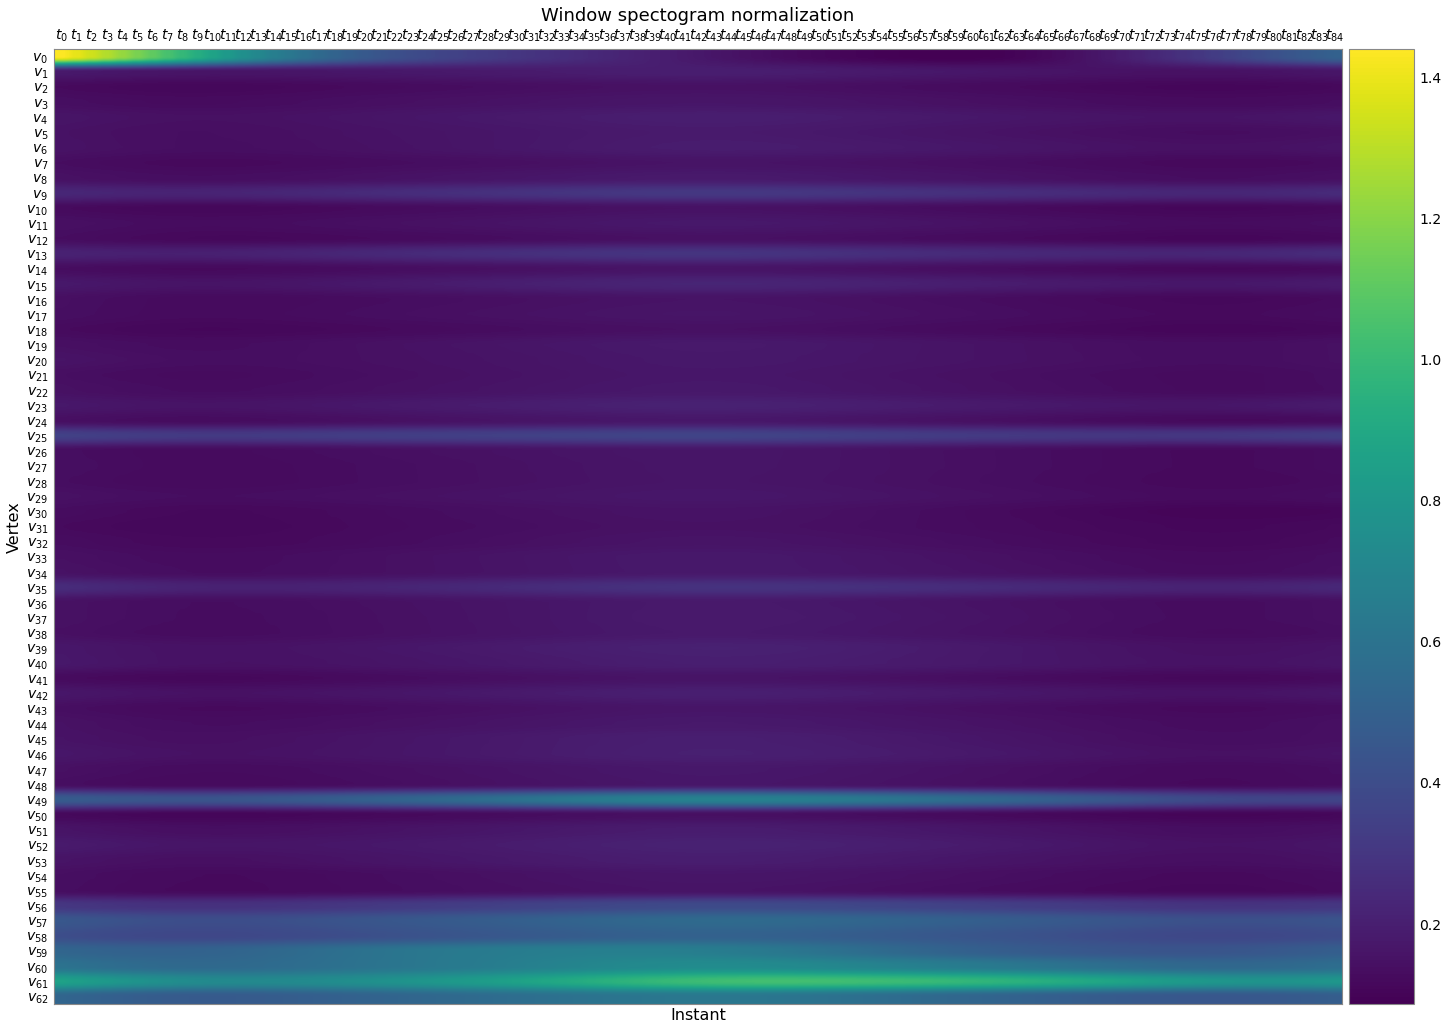

In [35]:
def norm_matrix_estimation(joint_spectogram, sw, tw):
    norm_matrix = np.zeros((joint_spectogram.shape[0] - sw,joint_spectogram.shape[1] - tw))
    for i in range(joint_spectogram.shape[0] - sw):
        for j in range(joint_spectogram.shape[1] - tw):
            norm_matrix[i,j] = np.linalg.norm(joint_spectogram[:,:,i:i + sw,j:j + tw])
    return norm_matrix

norm_matrix = norm_matrix_estimation(joint_spectogram, SPACE_WINDOW, TIME_WINDOW)
plot_matrix(norm_matrix, rows_labels = ["$v_{"+str(i)+"}$" for i in range(norm_matrix.shape[0])], 
            cols_labels = ["$t_{"+str(i)+"}$" for i in range(norm_matrix.shape[1])], 
            rows_title = "Vertex", cols_title = "Instant", title = "Window spectogram normalization", colorbar = True)

In [ ]:
import time, datetime
def dist_matrix_estimation(joint_spectogram, sw, tw, filename = None):
    N = (joint_spectogram.shape[0] - sw)*(joint_spectogram.shape[1] - tw)
    dist_matrix = np.zeros((N,N))
    i,j,count = 0,0,0
    if filename is not None and os.path.isfile(filename):
        return np.loadtxt(filename, delimiter = ',')
    for a_i in range(joint_spectogram.shape[0] - sw):
        for a_j in range(joint_spectogram.shape[1] - tw):
            wspectogram_A = joint_spectogram[:,:,a_i:a_i + sw, a_j:a_j + tw]
            for b_i in range(joint_spectogram.shape[0] - sw):
                for b_j in range(joint_spectogram.shape[1] - tw):
                    wspectogram_B = joint_spectogram[:,:,b_i:b_i + sw,b_j:b_j + tw]
                    dist_matrix[i,j] = np.linalg.norm(wspectogram_A - wspectogram_B)
                    j += 1
                    if count % 10000 == 0:
                        print("[INFO] Matrix processing. {}/{}".format(count + 1,N*N))
                    count += 1
            i, j = i + 1, 0
    if filename is not None: np.savetxt(filename, dist_matrix, delimiter = ',')
    return dist_matrix

print("[{}][INFO] Start matrix computation.".format(datetime.datetime.now().strftime("%d/%m/%y %H:%M:%S")))
dist_matrix = dist_matrix_estimation(joint_spectogram, SPACE_WINDOW, TIME_WINDOW, filename = './data/drift_joint_sp.csv')
print("[{}][INFO] Start matrix graph.".format(datetime.datetime.now().strftime("%d/%m/%y %H:%M:%S")))
plot_matrix(dist_matrix, rows_labels = ["$p_{"+str(i)+"}$" for i in range(dist_matrix.shape[0])], 
            cols_labels = ["$p_{"+str(i)+"}$" for i in range(dist_matrix.shape[1])], 
            rows_title = "Pair $(v_1,t_1)$", cols_title = "Pair $(v_2,t_2)$", 
            title = "Window spectogram Euclidian distance", colorbar = True)
print("[{}][INFO] Final matrix computation.".format(datetime.datetime.now().strftime("%d/%m/%y %H:%M:%S")))

[22/02/21 14:26:59][INFO] Start matrix computation.
[INFO] Matrix processing. 1/28676025
[INFO] Matrix processing. 10001/28676025
[INFO] Matrix processing. 20001/28676025
[INFO] Matrix processing. 30001/28676025
[INFO] Matrix processing. 40001/28676025
[INFO] Matrix processing. 50001/28676025
[INFO] Matrix processing. 60001/28676025
[INFO] Matrix processing. 70001/28676025
[INFO] Matrix processing. 80001/28676025
[INFO] Matrix processing. 90001/28676025
[INFO] Matrix processing. 100001/28676025
[INFO] Matrix processing. 110001/28676025
[INFO] Matrix processing. 120001/28676025
[INFO] Matrix processing. 130001/28676025
[INFO] Matrix processing. 140001/28676025
[INFO] Matrix processing. 150001/28676025
[INFO] Matrix processing. 160001/28676025
[INFO] Matrix processing. 170001/28676025
[INFO] Matrix processing. 180001/28676025
[INFO] Matrix processing. 190001/28676025
[INFO] Matrix processing. 200001/28676025
[INFO] Matrix processing. 210001/28676025
[INFO] Matrix processing. 220001/28676

## **Example with real sensor data**

In this section we will make an implementation with the real information about the location of the sensors to be treated in the project

### **Weight matrix**

In [ ]:
Theta, k = 4, 5   

First the adjacent matrix is imported then the thresholded Gaussian kernel weighting function is used to smooth the graph

In [ ]:
W = pd.read_csv('data/Pune_SensorLocationDistances.csv',header=0).set_index('0')
W.describe()

In [ ]:
Indices = [ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21,
            22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40,
            41, 42, 43, 45, 46, 48, 50, 51, 59]
W.columns = [int(x) for x in W.columns]
W= W.loc[Indices,Indices]


In [ ]:
fig = px.imshow(W)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

In [ ]:
Theta, k = 4, 6 #Choosen values of k and theta
W_normal = Norm_W(W.copy(),Theta,k) 
A=W_normal.values

In [ ]:
fig = px.imshow(W_normal)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

#### **Bandwidth Reduction** 

[source 1 ](https://https://algorist.com/problems/Bandwidth_Reduction.html)

[source 2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.reverse_cuthill_mckee.html)

In [ ]:
Theta, k = 4, 6
W_normal = Norm_W(W.copy(),Theta,k) #Theta = 0.1 , k = 0.7
A_b=W_normal.values

In [ ]:
#Function
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

#Function
def ReOrderGraph(A):
  csrMatrix = csr_matrix(A)
  perm = reverse_cuthill_mckee(csrMatrix)
  A_reorder = csrMatrix[perm, :][:, perm].toarray()
  return A_reorder

def Graph_Nodes(A):
  dt = [('len', float)]
  A = A.view(dt)
  G = nx.from_numpy_matrix(A)
  pos = nx.spring_layout(G, k=0.5*1/np.sqrt(len(G.nodes())), iterations=50)
  figure = pyplot.figure(figsize=(20, 10))
  nx.draw(G,pos=nx.spring_layout(G,pos=pos),with_labels = True)
  xyz = np.array([pos[v] for v in sorted(G)])
  return xyz

In [ ]:
import networkx as nx
A_reorder = ReOrderGraph(A_b)
xyz = Graph_Nodes(A_reorder)

In [ ]:
from pygsp import graphs

graph = graphs.Graph(A_reorder)
graph.set_coordinates(xyz)
graph.compute_fourier_basis()
plot_graph(graph)

In [ ]:
fig = px.imshow(A_reorder)
fig.update_layout(
    title='Adjacent matrix')
fig.show()

In [ ]:
graph = graphs.Graph(A_reorder)
graph.set_coordinates()
graph.compute_fourier_basis()

In [ ]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

def spectral_clustering(eigenvals, eigenvcts, n_clusters):
    """Spectral Clustering Algorithm."""
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return cluster

proj_df = project_and_transpose(graph.e, graph.U, 3)

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

inertias = []

k_candidates = range(1, 20)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)
    
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

### Signal definition
Now we create a function that defines the signal to be implemented on the space network. Let's see how each signal looks in all the vertex.

In [ ]:
matplotlib.rcParams["image.cmap"] = 'viridis'

# Constants
SPACE_GRAPH_ORDER, SPACE_KERNEL_SCALE = graph.N, 3 #40, 3
TIME_GRAPH_ORDER, TIME_KERNEL_SCALE = 50, 3
dT = 10.0/TIME_GRAPH_ORDER # Time sample
LEVEL_NOISE, BREAK_TIME, STD = 0.3, 20, 0.4 # LN, brownian Motion (BM) start-point and SD in BM

In [ ]:
# Functions to signal definition
def brownian(x0, n, dt, delta, out = None):
    # https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html
    x0 = np.asarray(x0)
    
    # For each element of x0, generate a sample of n numbers from a normal distribution.
    r = np.random.normal(0.0, delta, x0.shape + (n,))*np.sqrt(dt)
    
    # If `out` was not given, create an output array.
    if out is None: out = np.empty(r.shape)
        
    # This computes the Brownian motion by forming the cumulative sum of the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    return out
    
def drift_signal(SGO = SPACE_GRAPH_ORDER, TGO = TIME_GRAPH_ORDER, BT = BREAK_TIME, 
                 dT = 1.0, nl = 0.01, delta = 2.0, groups = None, drift_vertex = [0]):
    periods = 2
    if groups is None:
        signal = np.sin(np.linspace(0, (TGO//BT)*periods*np.pi, TGO)) # Signal base (until BREAK_TIME)
        time_series = np.ones((SGO,1))*signal[None] # Same signal for all nodes
    else:
        time_series = []
        for i in groups:
            t0 = 2*np.pi*i/len(np.unique(groups))
            t0 = np.pi*30.0/180.0 * i
            time_series += [np.sin(np.linspace(0,(TGO//BT)*periods*np.pi, TGO) + t0)]
        time_series = np.stack(time_series, axis = 0)
            
    time_series += nl * np.random.randn(*time_series.shape) # Add noise
    
    # Add Brownian Motion with t = BT start point
    for dv in drift_vertex:
        brownian(time_series[dv,BT - 1], TGO - BT, dT, delta, out = time_series[dv,BT:])
    return time_series

In [ ]:
# Signal definition
#groups = np.array([0]*15 + [1]*28)
groups = np.array([0]*5 + [1]*31 + [2]*7)

time_series = drift_signal(dT = dT, nl = LEVEL_NOISE, BT = BREAK_TIME, 
                           delta = STD, groups = groups, drift_vertex = [2])

t = np.linspace(0, TIME_GRAPH_ORDER*dT, TIME_GRAPH_ORDER)
t = np.ones((SPACE_GRAPH_ORDER,1))*t[None]
#plot_curves(t, time_series, xlabel = "time", ylabel = "Vertex-magnitud")

In [ ]:
import plotly.graph_objects as go
# Create traces
fig = go.Figure()
for i in range(len(time_series)):
  fig.add_trace(go.Scatter(x=t[i], y=time_series[i],
                    mode='lines',
                    name='Node'+str(i)))

fig.update_layout(
    title="Experimental signals",
    xaxis_title="Time",
    yaxis_title="Signal value")

fig.show()

The next graph shows the signal inside the space-time graph in a given time. For example, at time instant 3, it is observed that the network is divided into two sections because the signal strength is inverse for the groups created, that is, one group of nodes has a high value while the other has a low.

### **Space and time analysis**

In [ ]:
# Space-time graph definition
groups = np.array([0]*5 + [1]*31 + [2]*7)
space_time_graph = [graph, create_path_graph(TIME_GRAPH_ORDER)]

plot_graph(space_time_graph[0],groups)
plot_graph(space_time_graph[1])

In [ ]:
signal_graph_anima(space_time_graph, time_series)

#### **Vertex signal in time**
This section shows the evolution of the signal in time by vertex

In [ ]:
gft_signal_anima(space_time_graph[1], time_series, is_graph_space = True)

#### **Time evolution**

This section shows the evolution of the signal in time for all vertex

In [ ]:
gft_signal_anima(space_time_graph[0], time_series, is_graph_space = False)

#### **Joint Evolution**

The following graph shows the transformation of fourier in time in space. From the first graph it is possible to extract *the vertexes that have similar properties given an instant of time*, those that present similar variations in the signal. From the second it is possible to evaluate how the signal varies in time for a given vertex. *It is possible to determine at what moment the signal presents less variation (tendency to be constant)*.

In [ ]:
spectogram_anima(space_time_graph[0], time_series, SKS = SPACE_KERNEL_SCALE, 
                 is_graph_space = True, limits = [0.0, 0.5], lamdba_lim = None)

In the following graph, it is possible to determine the behavior of the signal for a given vertex in an instant of time, in the same graph. How constant is the signal of a vertex in a given time lapse

In [ ]:
spectogram_anima(space_time_graph[1], time_series, SKS = TIME_KERNEL_SCALE, 
                 is_graph_space = False, limits = None, lamdba_lim = None)

In [ ]:
kernels, joint_spectogram = JFT_anima(space_time_graph, time_series, [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE],
                                     lspace_lim = None, ltime_lim = None)

In [ ]:
wspectogram_A = joint_spectogram[:,:,1,11:31]
wspectogram_B = joint_spectogram[:,:,3,11:31]
norm= np.linalg.norm(wspectogram_A - wspectogram_B)
norm

In [ ]:
A = np.array([1,2,3,4,5,6])
A = A/np.sum(A)
print(A)
B = np.array([6,5,4,3,2,1])
B = B/np.sum(B)
print(B)
norm = np.linalg.norm(A - B)
norm

In [ ]:
joint_spectogram_aux = joint_spectogram[:,:,:,15:25]

In [ ]:
# filename = "./dist_drift_prueba_low_fase.csv"
filename = "./dist_drift_prueba_4_johan_todo.csv"
dist_matrix = plot_dist_matrix(joint_spectogram, sw=0,tw=3, filename = filename, overwrite = False, vlist = list(range(5)) + list(range(7,36)) + list(range(38,43))) #xlim = [100,250], ylim = [100,250]

In [ ]:
dist_matrix = plot_dist_matrix(joint_spectogram, sw = 0, tw = 3, filename = filename, vlist = [0,1,2,3,4]) #xlim = [100,250], ylim = [100,250]

### Clustering

In [ ]:
joint_spectogram.shape

In [ ]:
groups = [[0,1,2,3,4], list(range(5,36)), list(range(37,43))]
dist_matrix_groups = []
for group in groups:
    dist_matrix = dist_matrix_estimation(joint_spectogram, sw = 0, tw = 3, filename = filename, vlist = group)
    ind = np.tril_indices(dist_matrix.shape[0])
    aux_df = pd.DataFrame(dist_matrix.values[ind], columns = ['dist'])
    aux_df.index = dist_matrix.index[ind[0]] #+ '-' + dist_matrix.columns[ind[1]]
    dist_matrix_groups.append(aux_df)

In [ ]:
dist_matrix_groups
for dist in dist_matrix_groups:
    dist.hist(bins = 100)

In [ ]:
# from sklearn.cluster import DBSCAN
# import seaborn as sns
# import plotly.express as px

# X = dist_matrix_groups[1]
# clustering = DBSCAN(eps = 0.1, min_samples = 1).fit(X)

# # Graph
# X['labels'] = clustering.labels_
# fig = px.line(X, x = "dist", y = 'labels', color = 'labels')
# fig.show()

In [ ]:
# X[X['labels'] == 10].index

In [ ]:
from sklearn.mixture import GaussianMixture

X = dist_matrix_groups[0].copy()
lowest_bic = [np.infty, None]
bic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        print("[INFO] CV_type = {} with n_component = {}".format(cv_type, n_components))
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components = n_components, covariance_type = cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic[0]:
            lowest_bic = [bic[-1], cv_type]
            best_gmm = gmm
# clf = GaussianMixture(n_components = 10, covariance_type = 'full')
# clf.fit(X)

# Graph
X['labels'] = best_gmm.predict(X)
fig = px.line(X, x = "dist", y = 'labels', color = 'labels')
fig.show()

In [ ]:
print(lowest_bic)
plt.plot(bic)

In [ ]:
import re
print(lowest_bic)
drift = X[(X['labels'] == 2)].index.unique().to_list()
drift
# vlist = re.compile(r"\(([0-9]+),").findall("\n".join(drift))
# vlist

### Full cluster

In [ ]:
full_dist_matrix = dist_matrix_estimation(joint_spectogram, sw = 0, tw = 3, filename = filename)
ind = np.tril_indices(full_dist_matrix.shape[0])
drift_df = pd.DataFrame(full_dist_matrix.values[ind], columns = ['dist'])
drift_df.index = full_dist_matrix.index[ind[0]] #+ '-' + dist_matrix.columns[ind[1]]
drift_df.hist(bins = 100)

In [ ]:
from sklearn.mixture import GaussianMixture

X = drift_df.copy()
lowest_bic = [np.infty, None]
bic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        print("[INFO] CV_type = {} with n_component = {}".format(cv_type, n_components))
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components = n_components, covariance_type = cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic[0]:
            lowest_bic = [bic[-1], cv_type]
            best_gmm = gmm
# clf = GaussianMixture(n_components = 10, covariance_type = 'full')
# clf.fit(X)

# Graph
X['labels'] = best_gmm.predict(X)
fig = px.line(X, x = "dist", y = 'labels', color = 'labels')
fig.show()

In [ ]:
print(lowest_bic)
drift = X[(X['labels'] == 8)].index.unique().to_list()
drift

## ***Anexos: GitHub-Colab connection***
Here, some commands to upload/save the github respository

In [ ]:
''' Function definitions'''
# Git pull
def git_pull(repo_pwd, show_current_branch = False, make_commit = False): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        # !git config --list
        if show_current_branch: 
            !git branch 
        if make_commit:
            if "user_git" not in globals(): user_git = input("User github?: ")
            if "email_git" not in globals(): email_git = input("Email github?: ") 
            !git config --global user.email $email_git
            !git config --global user.name $user_git
            !git commit -am "Updating in colab"
        !git pull
        !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

# Git push
def git_push(repo_pwd): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        import getpass
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        if "user_git" not in globals(): user_git = input("User github?: ")
        if "email_git" not in globals(): email_git = input("Email github?: ")

        # Password login
        try: 
            pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
        except Exception as error: 
            print('ERROR', error) 

        # Upload from every where
        origin_git = !git config --get remote.origin.url
        origin_git = origin_git[0].replace("https://","https://{}:{}@".format(user_git,pwd_git))

        !git config --global user.email "$email_git"
        !git config --global user.name "$user_git"
        !git status

        x = " "
        while x.lower() != "y" and x.lower() != "n": x = input("Continue?...[y/n]: ")

        if x.lower() == "y":
            com_message = input("Enter the commit message: ")
            !git add .
            !git commit -am "$com_message"
            !git push "$origin"
            !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

In order to execute the functions, please unlock the respective function

In [ ]:
# git_pull(repo_pwd, show_current_branch = False, make_commit = True)
# git_push(repo_pwd)